In [920]:
import pandas as pd 
import numpy as np
from scipy import stats 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler,RobustScaler,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PowerTransformer
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings

warnings.filterwarnings('ignore')
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#statistical libraries 
from scipy import stats
from scipy.stats import zscore, skew 

import joblib

# set style for better visualizations 
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("libraries imported successfully!")


libraries imported successfully!


In [921]:
loan_df = pd.read_csv('home_loan_train.csv')

df = loan_df.copy()


In [922]:
# df.dropna(subset=['Credit_History'],inplace=True)

In [923]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [924]:
numerical =df.select_dtypes(include=['float64','int64']).columns

numerical=numerical.drop('Credit_History')

categorical = df.select_dtypes(include='object').columns
categorical = list(categorical)
categorical.append('Credit_History')

In [925]:
for col in categorical:
 x=df[col].mode()[0]
 df[col]=df[col].fillna(x)

for col in numerical:
  df[col]=df[col].fillna(df[col].mean())

In [926]:
df.duplicated().sum()

np.int64(0)

In [927]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [928]:
df['Loan_Amount_Term'].skew()

np.float64(-2.3896799467122745)

numerical
categorical
skewed_vars


In [929]:
scaler = StandardScaler()
df[numerical]= scaler.fit_transform(df[numerical])

In [930]:
df[numerical]

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
0,0.072991,-0.554487,0.000000,0.279851
1,-0.134412,-0.038732,-0.219273,0.279851
2,-0.393747,-0.554487,-0.957641,0.279851
3,-0.462062,0.251980,-0.314547,0.279851
4,0.097728,-0.554487,-0.064454,0.279851
...,...,...,...,...
609,-0.410130,-0.554487,-0.898095,0.279851
610,-0.212557,-0.554487,-1.267279,-2.518655
611,0.437174,-0.472404,1.269371,0.279851
612,0.357064,-0.554487,0.483367,0.279851


In [931]:
(df[numerical].std().mean())-1

np.float64(0.0008153283050325033)

In [932]:
# skewed_vars = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome','Loan_Amount_Term']

# for var in skewed_vars:
#     if var in df.columns:
#         if df[var].skew() > 0:
#             # Check if variable has zero or negative values
#             min_val = df[var].min()
#             if min_val <= 0 :
#                 if np.log1p(min_val) != 'nan':
#                     # Use log1p for variables with zeros
#                     df[f'{var}_log'] = np.log1p(df[var])
#                     print(f"✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)")
#                 else:
#                     df[f'{var}_log'] = np.log1p(df[var])
#                     print(f"✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)")
#             else:
#                 # Use log for positive values only
#                 df[f'{var}_log'] = np.log(df[var])
#                 print(f"✓ {var}: Applied log transformation")
#         else:
#             pt = PowerTransformer(method='yeo-johnson')
#             df[f'{var}_log'] = pt.fit_transform(df[var].values.reshape(-1,1))
#             print(f"✓ {var}: Applied yeo-johnsons transformation")
#     # Check skewness before and after
#     original_skew = skew(df[var])
#     transformed_skew = skew(df[f'{var}_log'])
#     print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")

# print(f"\nDataset shape after log transformation: {df.shape}")
# print("New log-transformed columns:", [col for col in df.columns if '_log' in col])


skewed_vars = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term']

for var in skewed_vars:
    if var in df.columns:
        # Ensure data is numeric before processing
        df[var] = pd.to_numeric(df[var], errors='coerce') 
        
        # We need to drop NaNs temporarily for accurate skewness calculation/min check
        data_subset = df[var].dropna() 
        
        if data_subset.empty:
            print(f"Skipping {var}: No data available after dropping NaNs.")
            continue

        original_skew = skew(data_subset)
        
        if original_skew > 0:
            # Check if variable has zero or negative values
            min_val = data_subset.min()
            
            # Use a robust transformation if zeros/negatives exist (Yeo-Johnson is best)
            if min_val <= 0:
                pt = PowerTransformer(method='yeo-johnson')
                # Fit_transform works robustly with zeros and negatives
                df[f'{var}_log'] = pt.fit_transform(df[var].values.reshape(-1, 1)).flatten()
                print(f"✓ {var}: Applied Yeo-Johnson transformation (handles negatives/zeros)")
            
            # If all values are positive and skewed, we can use simple log/log1p
            else: 
                # Use log1p if 0 is close, log otherwise
                df[f'{var}_log'] = np.log(df[var])
                print(f"✓ {var}: Applied natural log transformation")

        else:
            # If skewness is negative or handled differently, use Yeo-Johnson
            pt = PowerTransformer(method='yeo-johnson')
            df[f'{var}_log'] = pt.fit_transform(df[var].values.reshape(-1,1)).flatten()
            print(f"✓ {var}: Applied yeo-johnsons transformation (for negative skew)")
            
        # Check skewness after transformation
        transformed_skew = skew(df[f'{var}_log'].dropna())
        print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")

print(f"\nDataset shape after log transformation: {df.shape}")
print("New log-transformed columns:", [col for col in df.columns if '_log' in col])


✓ LoanAmount: Applied Yeo-Johnson transformation (handles negatives/zeros)
  Original skewness: 2.720 → Transformed skewness: -0.120
✓ ApplicantIncome: Applied Yeo-Johnson transformation (handles negatives/zeros)
  Original skewness: 6.524 → Transformed skewness: 0.137
✓ CoapplicantIncome: Applied Yeo-Johnson transformation (handles negatives/zeros)
  Original skewness: 7.473 → Transformed skewness: 0.297
✓ Loan_Amount_Term: Applied yeo-johnsons transformation (for negative skew)
  Original skewness: -2.384 → Transformed skewness: 1.148

Dataset shape after log transformation: (614, 17)
New log-transformed columns: ['LoanAmount_log', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'Loan_Amount_Term_log']


consider other transformation methods on subsequent evaluations because its over flipping the data i am now having negative skewness 

In [933]:
df['Dependents']=df['Dependents'].replace("3+",3)

In [934]:
df['Dependents'].value_counts()

Dependents
0    360
1    102
2    101
3     51
Name: count, dtype: int64

Handling outliers 

In [935]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'LoanAmount_log', 'ApplicantIncome_log', 'CoapplicantIncome_log',
       'Loan_Amount_Term_log'],
      dtype='object')

In [936]:
# univariate analysis of the 
def univariate_numerical_eda(df, column):
    """
    Performs univariate EDA on a single numerical column.
    Displays summary statistics, skewness, kurtosis, histogram, KDE, and boxplot.
    """
    print(f" Feature: {column}")
    print("="*40)
    print(df[column].describe().to_frame())
    print(f"\nSkewness: {df[column].skew():.3f}")
    print(f"Kurtosis: {df[column].kurt():.3f}")

    plt.figure(figsize=(12,4))

    # Histogram + KDE
    plt.subplot(1,2,1)
    sns.histplot(df[column], kde=True, bins=30, color='teal')
    plt.title(f'\n Distribution of {column}', fontsize=13)
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[column], color='teal')
    plt.title(f'\n Boxplot of {column}', fontsize=13)

    plt.tight_layout()
    plt.show()

    # Optional note on transformation
    if abs(df[column].skew()) > 1:
        print(f"\n {column} is highly skewed. Consider log or Box-Cox transformation.")
    elif abs(df[column].skew()) > 0.5:
        print(f"{column} is moderately skewed.")
    else:
        print(f"{column} is fairly symmetric.")


['LoanAmount_log', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'Loan_Amount_Term_log']
 Feature: LoanAmount_log
       LoanAmount_log
count    6.140000e+02
mean    -4.918252e-17
std      1.000815e+00
min     -3.495963e+00
25%     -5.862800e-01
50%      2.252809e-02
75%      5.758511e-01
max      3.002401e+00

Skewness: -0.120
Kurtosis: 0.747


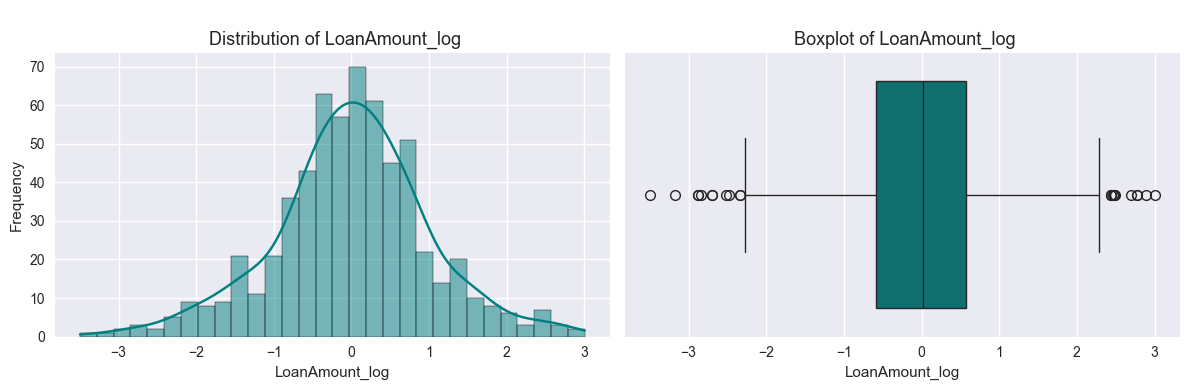

LoanAmount_log is fairly symmetric.
 Feature: ApplicantIncome_log
       ApplicantIncome_log
count         6.140000e+02
mean         -8.462286e-17
std           1.000815e+00
min          -3.269100e+00
25%          -6.903788e-01
50%          -1.084723e-01
75%           7.231155e-01
max           2.479425e+00

Skewness: 0.137
Kurtosis: -0.163


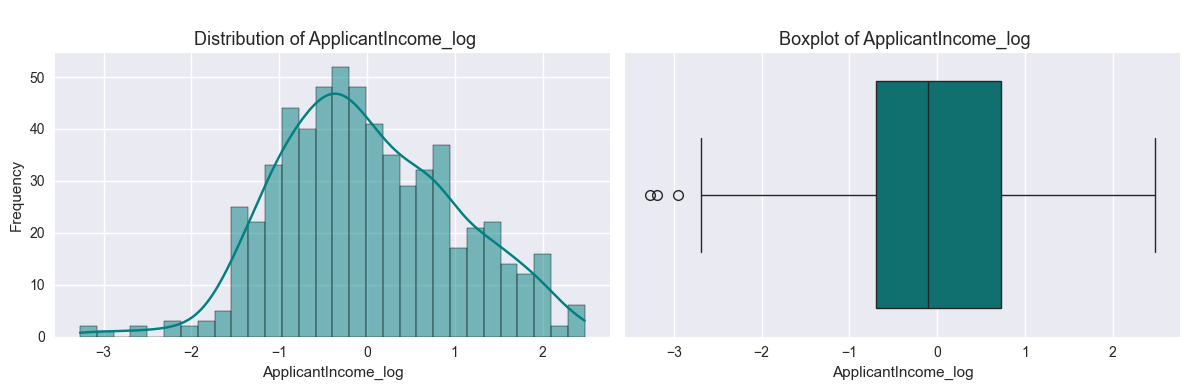

ApplicantIncome_log is fairly symmetric.
 Feature: CoapplicantIncome_log
       CoapplicantIncome_log
count           6.140000e+02
mean            5.786179e-17
std             1.000815e+00
min            -1.012525e+00
25%            -1.012525e+00
50%             1.698691e-01
75%             8.172008e-01
max             2.853709e+00

Skewness: 0.298
Kurtosis: -1.265


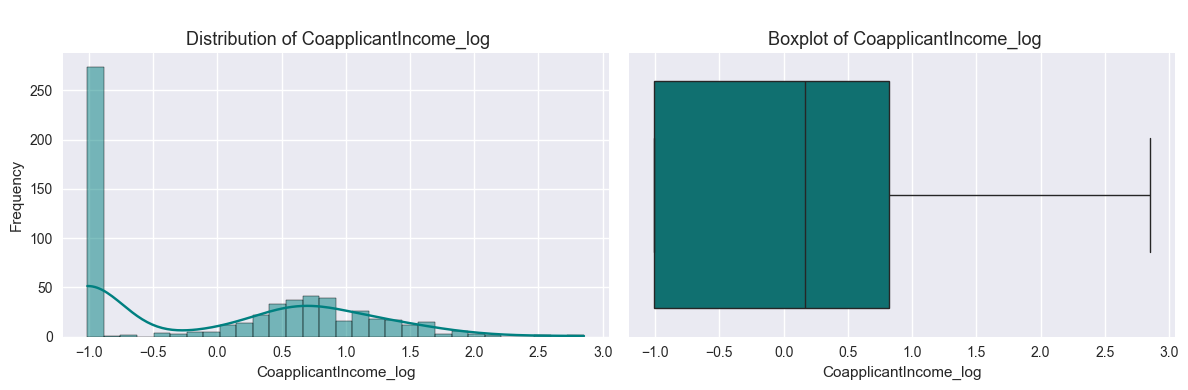

CoapplicantIncome_log is fairly symmetric.
 Feature: Loan_Amount_Term_log
       Loan_Amount_Term_log
count          6.140000e+02
mean           1.446545e-17
std            1.000815e+00
min           -3.051838e+00
25%            1.517139e-01
50%            1.517139e-01
75%            1.517139e-01
max            4.496148e+00

Skewness: 1.151
Kurtosis: 9.541


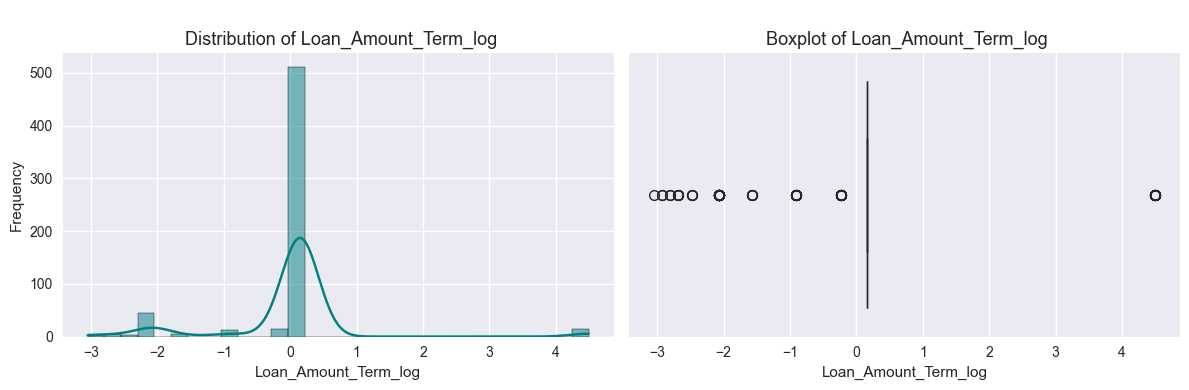


 Loan_Amount_Term_log is highly skewed. Consider log or Box-Cox transformation.


In [937]:
numer= [column for column in df.columns if  any( keyword in column.lower() for keyword in ['log'])]
print(numer)
for column in numer:
    univariate_numerical_eda(df,column)

we still have outliers so i move forward if handling them using Robust scaler

In [938]:
# for column in numer:
#     univariate_numerical_eda(df,column)

In [939]:
df['Loan_to_Income_Ratio'] = (df['LoanAmount_log']) / (df['ApplicantIncome_log'] + df['CoapplicantIncome_log'])

df['Total_Income']= df['ApplicantIncome']  +	df['CoapplicantIncome']

# Feature 1: People per Dollar (Inverse of Income per person)
# Lower value indicates more people sharing the income
df['amountspent_Per_Person'] = df['Total_Income'] / (df['Dependents'].astype(int) + 1) # Add 1 for the applicant

# Combine married status and dependents count into a single indicator
df['Household_Load'] = df['Dependents'].astype(int) + df['Married'].map({'No': 1, 'Yes': 2})



Ecncoding 

In [940]:
df['Property_Area'].nunique()

3

In [941]:
categorical.remove('Property_Area')

In [942]:
y= df['Loan_Status']
Y= pd.Series(y, name='Loan_Status')

df.drop('Loan_Status',axis=1,inplace=True)
df.drop('Loan_ID',axis=1,inplace=True)

In [943]:

Y = Y.map({'Y': 1, 'N': 0})

In [944]:

for num in df.columns:
    if num in numerical:
        df=df.drop(num,axis=1)


In [945]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,LoanAmount_log,ApplicantIncome_log,CoapplicantIncome_log,Loan_Amount_Term_log,Loan_to_Income_Ratio,Total_Income,amountspent_Per_Person,Household_Load
0,Male,No,0,Graduate,No,1.0,Urban,0.318998,0.739332,-1.012525,0.151714,-1.167664,-0.481497,-0.481497,1
1,Male,Yes,1,Graduate,No,1.0,Rural,0.003844,0.274368,0.395705,0.151714,0.005737,-0.173144,-0.086572,3
2,Male,Yes,0,Graduate,Yes,1.0,Urban,-1.504597,-0.606297,-1.012525,0.151714,0.929439,-0.948235,-0.948235,2
3,Male,Yes,0,Not Graduate,No,1.0,Urban,-0.152101,-0.902689,0.843513,0.151714,2.570274,-0.210083,-0.210083,2
4,Male,No,0,Graduate,No,1.0,Urban,0.232699,0.783253,-1.012525,0.151714,-1.014950,-0.456759,-0.456759,1


Splitting data

now lets split

In [946]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    df, Y, test_size=0.2, random_state=42, stratify=Y)

# First split: 80% train+val, 20% test
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)



In [947]:
X_val['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [948]:
X_train['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [949]:
lenc= LabelEncoder()
label = OneHotEncoder(sparse_output=False, drop="first")
ordlabel=OrdinalEncoder(categories=[['Rural', 'Semiurban', 'Urban']])
labelencoded=['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History']
OneHotEncoded=['Dependents']
OrdinalEncoded=['Property_Area']

for labels in labelencoded:
    X_train[labels]= lenc.fit_transform(X_train[labels])
    joblib.dump(lenc,f'{labels}labelencoder.pk1')

print(f'{labelencoded} encoded')


 
X_train[OneHotEncoded]=X_train[OneHotEncoded].astype(str)
encoded=label.fit_transform(X_train[OneHotEncoded])
joblib.dump(encoded,'onehotencoder.pk1')

print(f'{OneHotEncoded} encoded')


X_train[OrdinalEncoded]=X_train[OrdinalEncoded].astype(str)
X_train[OrdinalEncoded]=ordlabel.fit_transform(X_train[OrdinalEncoded])
joblib.dump(ordlabel,'ordinalencoder.pk1')
print(f'{OrdinalEncoded} encoded')


['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History'] encoded
['Dependents'] encoded
['Property_Area'] encoded


In [950]:
OrdinalEncoded

['Property_Area']

In [951]:
lenc= LabelEncoder()
label = OneHotEncoder(sparse_output=False, drop="first")
ordlabel=OrdinalEncoder(categories=[['Rural', 'Semiurban', 'Urban']])
for nin in labelencoded:
    for dfs in [X_val,X_test]:
        dfs[nin]=dfs[nin].astype(str)
        dfs[nin]= lenc.fit_transform(dfs[nin])
        print(f'{nin} encoded')

for lcd in OneHotEncoded:
    for dfs in [X_val,X_test]:
        try:
            dfs[lcd]=dfs[lcd].astype(int)

        except Exception as e: 
            dfs[lcd]=dfs[lcd].astype(str)
        encoded=label.fit_transform(dfs[[lcd]])
        print(f'{lcd} encoded')

for x in OrdinalEncoded:
    for dfs in [X_val,X_test]:
        dfs[x]=dfs[x].astype(str)
        dfs[x]=ordlabel.fit_transform(dfs[[x]])
        print(f'{x} encoded')


Gender encoded
Gender encoded
Married encoded
Married encoded
Education encoded
Education encoded
Self_Employed encoded
Self_Employed encoded
Credit_History encoded
Credit_History encoded
Dependents encoded
Dependents encoded
Property_Area encoded
Property_Area encoded


=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 features by correlation with quality:
 1. Credit_History: 0.510
 2. Education: 0.114
 3. Property_Area: 0.082
 4. Loan_Amount_Term_log: 0.056
 5. Total_Income: 0.049
 6. Household_Load: 0.038
 7. Married: 0.032
 8. Dependents: 0.031
 9. LoanAmount_log: 0.030
10. amountspent_Per_Person: 0.026

Engineered features in top 10: ['LoanAmount_log', 'Loan_Amount_Term_log', 'Household_Load']


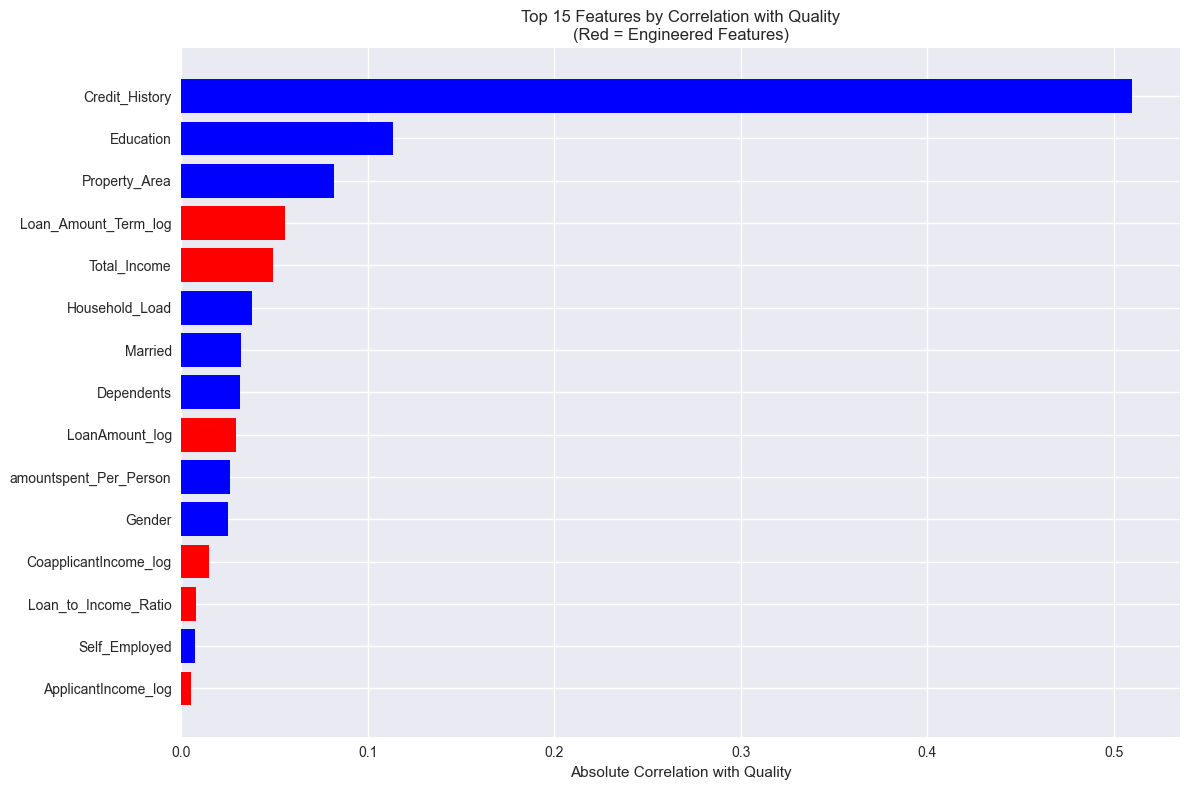


✓ Feature importance analysis completed
✓ 3 engineered features in top 10


In [952]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Calculate correlation with target for all features
feature_correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)


print("Top 10 features by correlation with quality:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in df.columns if any(keyword in col.lower() for keyword in ['ratio','load','spent' 'total', 'log'])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Quality')
plt.title('Top 15 Features by Correlation with Quality\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


In [953]:
selected_features= X_train.corrwith(y_train).abs().sort_values(ascending=False).head(10)
selected_features

Credit_History            0.510093
Education                 0.113707
Property_Area             0.082055
Loan_Amount_Term_log      0.055651
Total_Income              0.049215
Household_Load            0.037625
Married                   0.031847
Dependents                0.031451
LoanAmount_log            0.029576
amountspent_Per_Person    0.025884
dtype: float64

In [954]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Credit_History', 'Property_Area', 'LoanAmount_log',
       'ApplicantIncome_log', 'CoapplicantIncome_log', 'Loan_Amount_Term_log',
       'Loan_to_Income_Ratio', 'Total_Income', 'amountspent_Per_Person',
       'Household_Load'],
      dtype='object')

In [955]:
print("SAVING PREPROCESSED DATA ")

# Save scaled datasets
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)


joblib.dump(selected_features.index,'selectedfeatures.pk1')
joblib.dump(scaler,'standardscaler.pk1')


SAVING PREPROCESSED DATA 


['standardscaler.pk1']

In [956]:
X_train.isnull().sum()

Gender                    0
Married                   0
Dependents                0
Education                 0
Self_Employed             0
Credit_History            0
Property_Area             0
LoanAmount_log            0
ApplicantIncome_log       0
CoapplicantIncome_log     0
Loan_Amount_Term_log      0
Loan_to_Income_Ratio      0
Total_Income              0
amountspent_Per_Person    0
Household_Load            0
dtype: int64